Class imbalance check 

Total rows considered: 7110

Counts:
Priority
Minor       5635
Critical     803
Major        672

Proportions (%):
Priority
Minor       79.25%
Critical    11.29%
Major        9.45%
Name: count, dtype: object

Metrics:
- Majority class: Minor (79.25%)
- Gini impurity: 0.3502
- Dominance (sum p_i^2): 0.6498

Heuristics:
- Any rare classes (<5%): False
- Majority dominance >70%: True
- High dominance score >0.60: True

Assessment: Potential class imbalance detected.


C:\Users\thant\AppData\Local\Temp\ipykernel_22152\4198215195.py:72: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x=counts.loc[order].index, y=counts.loc[order].values, palette=palette)


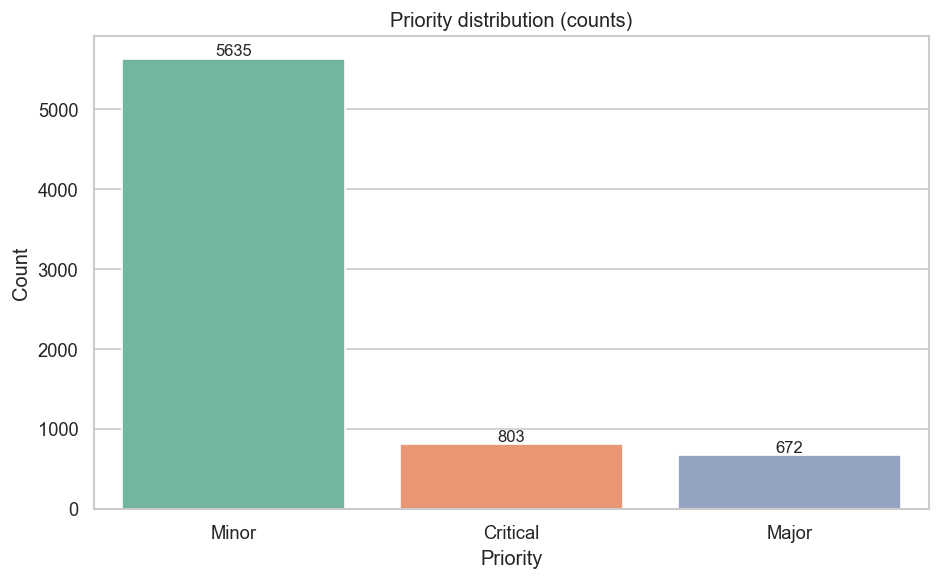

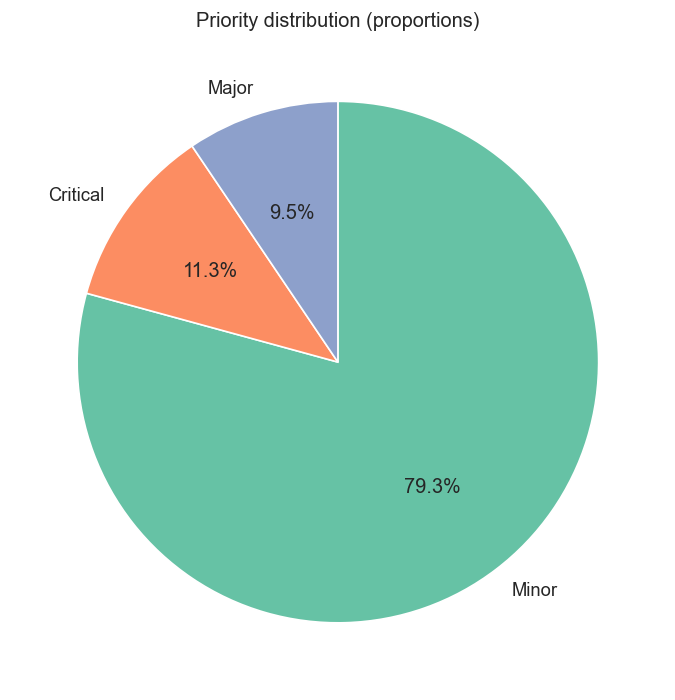

C:\Users\thant\AppData\Local\Temp\ipykernel_22152\4198215195.py:107: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x=(proportions.values * 100), y=proportions.index, palette=palette)


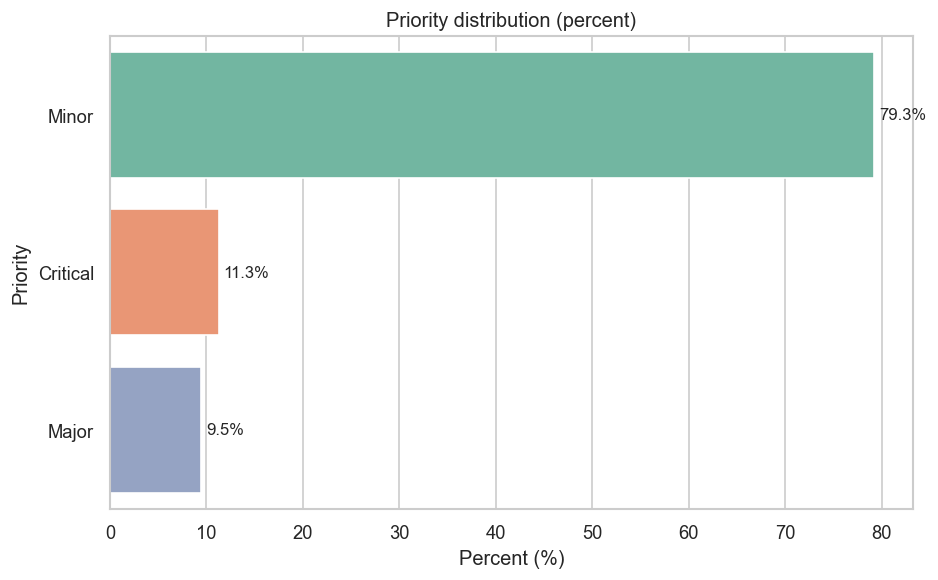

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from textwrap import wrap

# --- Configuration ---
CSV_PATH = 'alert_raw.csv'       # change to your CSV path
COLUMN = 'Priority'         # change to your column name
SAVE_FIGS = False           # set True to save images next to the script
FIG_DPI = 120

# Thresholds (tweak to your context)
RARE_CLASS_THRESHOLD = 0.05      # any class with <5% frequency is considered rare
MAJORITY_DOMINANCE = 0.70        # if top class >70%, considered strongly imbalanced
DOMINANCE_THRESHOLD = 0.60       # dominance = sum(p_i^2); higher => more dominated

# --- Load & clean ---
df = pd.read_csv(CSV_PATH)

if COLUMN not in df.columns:
    raise ValueError(f"Column '{COLUMN}' not found in CSV. Available columns: {list(df.columns)}")

s = df[COLUMN].astype(str).str.strip()
s = s.replace({'': pd.NA, 'nan': pd.NA, 'None': pd.NA}).dropna()

# Basic distribution
n = len(s)
counts = s.value_counts()
proportions = (counts / n).sort_values(ascending=False)

# Metrics
ps = proportions.values
gini_impurity = 1 - (ps**2).sum()
dominance = (ps**2).sum()
majority_class = proportions.index[0]
majority_share = proportions.iloc[0]

# Heuristics
has_rare = (proportions < RARE_CLASS_THRESHOLD).any()
strong_dominance = majority_share > MAJORITY_DOMINANCE
high_dominance = dominance > DOMINANCE_THRESHOLD

# --- Print summary ---
print(f"Total rows considered: {n}\n")
print("Counts:")
print(counts.to_string())
print("\nProportions (%):")
print((proportions * 100).round(2).astype(str) + '%')

print("\nMetrics:")
print(f"- Majority class: {majority_class} ({majority_share*100:.2f}%)")
print(f"- Gini impurity: {gini_impurity:.4f}")
print(f"- Dominance (sum p_i^2): {dominance:.4f}")

print("\nHeuristics:")
print(f"- Any rare classes (<{RARE_CLASS_THRESHOLD*100:.0f}%): {bool(has_rare)}")
print(f"- Majority dominance >{MAJORITY_DOMINANCE*100:.0f}%: {bool(strong_dominance)}")
print(f"- High dominance score >{DOMINANCE_THRESHOLD:.2f}: {bool(high_dominance)}")

if strong_dominance or has_rare or high_dominance:
    print("\nAssessment: Potential class imbalance detected.")
else:
    print("\nAssessment: Distribution looks reasonably balanced.")

# --- Plotting style ---
sns.set(style="whitegrid")
palette = sns.color_palette("Set2", n_colors=len(proportions))

# --- Figure 1: Bar chart (counts) ---
plt.figure(figsize=(8, 5), dpi=FIG_DPI)
order = counts.sort_values(ascending=False).index
ax = sns.barplot(x=counts.loc[order].index, y=counts.loc[order].values, palette=palette)
ax.set_title("\n".join(wrap(f"{COLUMN} distribution (counts)", width=60)))
ax.set_xlabel(COLUMN)
ax.set_ylabel("Count")

# Add value labels
for p in ax.patches:
    height = p.get_height()
    ax.annotate(f"{int(height)}",
                (p.get_x() + p.get_width() / 2, height),
                ha='center', va='bottom', fontsize=10)

plt.tight_layout()
if SAVE_FIGS:
    plt.savefig("severity_counts_bar.png", bbox_inches="tight", dpi=FIG_DPI)
plt.show()

# --- Figure 2: Pie chart (proportions) ---
plt.figure(figsize=(6, 6), dpi=FIG_DPI)
plt.pie(proportions.values,
        labels=proportions.index,
        autopct=lambda p: f"{p:.1f}%" if p >= 1 else "<1%",
        colors=palette,
        startangle=90,
        counterclock=False,
        wedgeprops=dict(edgecolor='white'))

plt.title("\n".join(wrap(f"{COLUMN} distribution (proportions)", width=60)))
plt.tight_layout()
if SAVE_FIGS:
    plt.savefig("severity_proportions_pie.png", bbox_inches="tight", dpi=FIG_DPI)
plt.show()

# --- Optional: Horizontal bar with percentages ---
plt.figure(figsize=(8, 5), dpi=FIG_DPI)
ax = sns.barplot(x=(proportions.values * 100), y=proportions.index, palette=palette)
ax.set_title("\n".join(wrap(f"{COLUMN} distribution (percent)", width=60)))
ax.set_xlabel("Percent (%)")
ax.set_ylabel(COLUMN)

for i, v in enumerate((proportions.values * 100)):
    ax.text(v + 0.5, i, f"{v:.1f}%", va='center', fontsize=10)

plt.tight_layout()
if SAVE_FIGS:
    plt.savefig("severity_percent_barh.png", bbox_inches="tight", dpi=FIG_DPI)
plt.show()
